In [119]:
from dotenv import load_dotenv
import os
import requests
import json
from langchain_openai import OpenAI
from langchain.chains import LLMChain
import re
from faker import Faker
import pandas as pd
import matplotlib.pyplot as plt
import time

In [18]:
load_dotenv()

True

Checks that the OpenRouter API key is in the env file.

In [20]:

OPENROUTER_API_KEY = os.environ["OPENROUTER_API_KEY"]
if OPENROUTER_API_KEY is None:
    raise ValueError("OPENROUTER_API_KEY does not exist, add it to env")

**Generate syntethic data**

If you need to create synthetic data can you run this cell that will generate data with made up PII which can be used to test the system

In [23]:
import openai

#Enter the name of the folder where the texts will be generated.
#Creates a new folder if one does not exist
output_folder = "generated_texts"
os.makedirs(output_folder, exist_ok=True)

prompt = f"""
Jag skapar output träningsdata som ska användas för att testa min modell.
Användandet ska vara till att generera en löpande text som ska innehålla dummy data av påhittad personlig känslig information.
Generera endast en löpande text, ingen annan output, ingen förklaring eller sammanfattningar

Exempel på hur texten kan se ut:
'Jag träffade en person som hette Johan Svensson igår. Han gav mig sitt telefonnummer 123-456-7890 samt hans e-postadress johan.svensson@gmail.com ...'

Personlig känslig information inkluderar oftast:
Person/Namn - Detta inkluderar förnamn, mellannamn, efternamn eller hela namn på individer.
Telefonnummer - Alla telefonnummer, inklusive avgiftsfria nummer.
Adress - Kompletta eller partiella adresser, inklusive gata, postnummer, husnummer, stad och stat.
E-post - Alla e-postadresser.
Numeriskt Identifierare - Alla numeriska eller alfanumeriska identifierare som ärendenummer, medlemsnummer, biljettnummer, bankkontonummer,
IP-adresser, produktnycklar, serienummer, spårningsnummer för frakt, etc.
Kreditkort - Alla kreditkortsnummer, säkerhetskoder eller utgångsdatum.
"""
    
def query(prompt, temperature=0.8):
    response = requests.post(
        url="https://openrouter.ai/api/v1/chat/completions",
        headers={
            "Authorization": f"Bearer {OPENROUTER_API_KEY}",
            "Content-Type": "application/json"
        },
        data=json.dumps({
            "model": "openai/gpt-4-turbo",  # using openai gpt4 turbo for the generating of texts
            "messages": [
                {"role": "system", "content": "Du är en hjälpful assistent, designad för att generera text data."},
                {"role": "user", "content": prompt}
            ],
            "temperature": temperature,  #  influences the variety in the model's responses, is set in the function parameter.
            "max_tokens": 300 
        })
    )

    if response.status_code == 200:
        response_data = response.json()
        return response_data['choices'][0]['message']['content']
    else:
        raise Exception(f"API request failed with status code {response.status_code}: {response.text}")


for i in range(100):  # Enter the amout of texts to generate
    res = query(prompt)
    file_path = os.path.join(output_folder, f"text_{i+1}.txt")
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(res)
    
print("Texter genererade och sparade.")


Texter genererade och sparade.


**Marking Agent llama-3-8b-instruct**

Responsible for marking PII in the text using the Meta llama v3 8b-instructions via the OpenRouter API.
Currently are these PII types recognized, Person/name, Phone number, Address, Emails, Numeric identifiers, credit cards

In [133]:

prompt_template = """
Du är en säkerhetsassistent.
Din uppgift är att identifiera all personligt identifierbar information (PII).
När du hittar PII, markera den med de specifika taggarna <name>, <phone>, <email>, etc. som i exemplen nedan.
Markera endast texten, skriv ingenting annat. Skriv inga förklaringar eller sammanfattningar, endast markeringar.

Exempel på hur texten ska markeras:
'Jag träffade en person som hette <name> Johan Svensson </name> igår. Han gav mig sitt telefonnummer <phone> 123-456-7890 </phone> samt hans e-postadress <email> johan.svensson@gmail.com </email>.'
'Min vän <name> Maria </name> bor på <address> Storgatan 1, 12345 Stockholm </address>. Hennes IP-adress är <numerical> 192.168.1.1 </numerical>.'
'Kundens kreditkortsnummer är <creditcard> 1234-5678-9876-5432 </creditcard> med utgångsdatum <creditcard> 12/23 </creditcard>.'

Personlig känslig information (PII) inkluderar:
    Person/Namn - Detta inkluderar förnamn, mellannamn, efternamn eller hela namn på individer (inklusive enskilda förnamn eller efternamn, inte bara fullständiga namn.).
    Telefonnummer - Alla telefonnummer, inklusive avgiftsfria nummer.
    Adress - Kompletta eller partiella adresser, inklusive gata, postnummer, husnummer, stad och stat.
    E-post - Alla e-postadresser.
    Numeriskt Identifierare - Alla numeriska eller alfanumeriska identifierare som ärendenummer, medlemsnummer, biljettnummer, bankkontonummer, IP-adresser, produktnycklar, serienummer, spårningsnummer för frakt, etc.
    Kreditkort - Alla kreditkortsnummer, säkerhetskoder eller utgångsdatum.
"""


def query(text):
    prompt = prompt_template + "\n\nText:\n" + text
    response = requests.post(
        url="https://openrouter.ai/api/v1/chat/completions",
        headers={
            "Authorization": f"Bearer {OPENROUTER_API_KEY}",
            "Content-Type": "application/json"
        },
        data=json.dumps({
            "model": "meta-llama/llama-3-8b-instruct",
            "messages": [
                {"role": "system", "content": "Du är en hjälpful assistent, designad för att markera PII i text."},
                {"role": "user", "content": prompt}
            ]
        })
    )

    if response.status_code == 200:
        response_data = response.json()
        return response_data['choices'][0]['message']['content']
    else:
        raise Exception(f"API request failed with status code {response.status_code}: {response.text}")

def process_folder(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    total_start_time = time.time()
    for filename in os.listdir(input_folder):
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, filename)

        if os.path.isfile(input_path):
            with open(input_path, 'r', encoding='utf-8') as file:
                text = file.read()
            
            marked_text = query(text)
            
            with open(output_path, 'w', encoding='utf-8') as file:
                file.write(marked_text)

    total_end_time = time.time()  # End timing for all files
    total_time = total_end_time - total_start_time

    # Print total processing time
    print(f"Total processing time for all files: {total_time:.2f} seconds.")

input_folder = "generated_texts"  # Input folder name
output_folder = "marked_texts/llama8b"    # Output folder name

process_folder(input_folder, output_folder)
print("Marking complete.")


Total processing time for all files: 406.60 seconds.
Marking complete.


**Marking Agent llama-3-70b-instruct**

In [121]:

prompt_template = """
Du är en säkerhetsassistent.
Din uppgift är att identifiera all personligt identifierbar information (PII).
När du hittar PII, markera den med de specifika taggarna <name>, <phone>, <email>, etc. som i exemplen nedan.
Markera endast texten, skriv ingenting annat. Skriv inga förklaringar eller sammanfattningar, endast markeringar.

Exempel på hur texten ska markeras:
'Jag träffade en person som hette <name> Johan Svensson </name> igår. Han gav mig sitt telefonnummer <phone> 123-456-7890 </phone> samt hans e-postadress <email> johan.svensson@gmail.com </email>.'
'Min vän <name> Maria </name> bor på <address> Storgatan 1, 12345 Stockholm </address>. Hennes IP-adress är <numerical> 192.168.1.1 </numerical>.'
'Kundens kreditkortsnummer är <creditcard> 1234-5678-9876-5432 </creditcard> med utgångsdatum <creditcard> 12/23 </creditcard>.'

Personlig identifierbar information (PII) inkluderar:
    Person/Namn - Detta inkluderar förnamn, mellannamn, efternamn eller hela namn på individer (inklusive enskilda förnamn eller efternamn, inte bara fullständiga namn).
    Telefonnummer - Alla telefonnummer, inklusive avgiftsfria nummer.
    Adress - Kompletta eller partiella adresser, inklusive gata, postnummer, husnummer, stad och stat.
    E-post - Alla e-postadresser.
    Numeriskt Identifierare - Alla numeriska eller alfanumeriska identifierare som ärendenummer, medlemsnummer, biljettnummer, bankkontonummer, IP-adresser, produktnycklar, serienummer, spårningsnummer för frakt, etc.
    Kreditkort - Alla kreditkortsnummer, säkerhetskoder eller utgångsdatum.
"""


def query(text):
    prompt = prompt_template + "\n\nText:\n" + text
    response = requests.post(
        url="https://openrouter.ai/api/v1/chat/completions",
        headers={
            "Authorization": f"Bearer {OPENROUTER_API_KEY}",
            "Content-Type": "application/json"
        },
        data=json.dumps({
            "model": "meta-llama/llama-3-70b-instruct",
            "messages": [
                {"role": "system", "content": "Du är en hjälpful assistent, designad för att markera PII i text."},
                {"role": "user", "content": prompt}
            ]
        })
    )

    if response.status_code == 200:
        response_data = response.json()
        return response_data['choices'][0]['message']['content']
    else:
        raise Exception(f"API request failed with status code {response.status_code}: {response.text}")

def process_folder(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    total_start_time = time.time()
    for filename in os.listdir(input_folder):
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, filename)

        if os.path.isfile(input_path):
            with open(input_path, 'r', encoding='utf-8') as file:
                text = file.read()
            
            marked_text = query(text)
            
            with open(output_path, 'w', encoding='utf-8') as file:
                file.write(marked_text)

    total_end_time = time.time()  # End timing for all files
    total_time = total_end_time - total_start_time

    # Print total processing time
    print(f"Total processing time for all files: {total_time:.2f} seconds.")

input_folder = "generated_texts"  # Input folder name
output_folder = "marked_texts/llama70b"    # Output folder name

process_folder(input_folder, output_folder)
print("Marking complete.")


Total processing time for all files: 773.23 seconds.
Marking complete.


**Marking Agent qwen-110b**

In [135]:

prompt_template = """
Du är en säkerhetsassistent.
Din uppgift är att identifiera all personligt identifierbar information (PII).
När du hittar PII, markera den med de specifika taggarna <name>, <phone>, <email>, etc. som i exemplen nedan.
Markera endast texten, skriv ingenting annat. Skriv inga förklaringar eller sammanfattningar, endast markeringar.

Exempel på hur texten ska markeras:
'Jag träffade en person som hette <name> Johan Svensson </name> igår. Han gav mig sitt telefonnummer <phone> 123-456-7890 </phone> samt hans e-postadress <email> johan.svensson@gmail.com </email>.'
'Min vän <name> Maria </name> bor på <address> Storgatan 1, 12345 Stockholm </address>. Hennes IP-adress är <numerical> 192.168.1.1 </numerical>.'
'Kundens kreditkortsnummer är <creditcard> 1234-5678-9876-5432 </creditcard> med utgångsdatum <creditcard> 12/23 </creditcard>.'

Personlig känslig information (PII) inkluderar:
    Person/Namn - Detta inkluderar förnamn, mellannamn, efternamn eller hela namn på individer (inklusive enskilda förnamn eller efternamn, inte bara fullständiga namn).
    Telefonnummer - Alla telefonnummer, inklusive avgiftsfria nummer.
    Adress - Kompletta eller partiella adresser, inklusive gata, postnummer, husnummer, stad och stat.
    E-post - Alla e-postadresser.
    Numeriskt Identifierare - Alla numeriska eller alfanumeriska identifierare som ärendenummer, medlemsnummer, biljettnummer, bankkontonummer, IP-adresser, produktnycklar, serienummer, spårningsnummer för frakt, etc.
    Kreditkort - Alla kreditkortsnummer, säkerhetskoder eller utgångsdatum.
"""


def query(text):
    prompt = prompt_template + "\n\nText:\n" + text
    response = requests.post(
        url="https://openrouter.ai/api/v1/chat/completions",
        headers={
            "Authorization": f"Bearer {OPENROUTER_API_KEY}",
            "Content-Type": "application/json"
        },
        data=json.dumps({
            "model": "qwen/qwen-110b-chat",
            "messages": [
                {"role": "system", "content": "Du är en hjälpful assistent, designad för att markera PII i text."},
                {"role": "user", "content": prompt}
            ]
        })
    )

    if response.status_code == 200:
        response_data = response.json()
        return response_data['choices'][0]['message']['content']
    else:
        raise Exception(f"API request failed with status code {response.status_code}: {response.text}")

def process_folder(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    total_start_time = time.time()
    for filename in os.listdir(input_folder):
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, filename)

        if os.path.isfile(input_path):
            with open(input_path, 'r', encoding='utf-8') as file:
                text = file.read()
            
            marked_text = query(text)
            
            with open(output_path, 'w', encoding='utf-8') as file:
                file.write(marked_text)


    total_end_time = time.time()  # End timing for all files
    total_time = total_end_time - total_start_time

    # Print total processing time
    print(f"Total processing time for all files: {total_time:.2f} seconds.")
    
input_folder = "generated_texts"  # Input folder name
output_folder = "marked_texts/qwen110b"    # Output folder name

process_folder(input_folder, output_folder)
print("Marking complete.")


Total processing time for all files: 639.66 seconds.
Marking complete.


**Anonymization agent**

Replaces the markers with an anonymization tag

In [139]:
def anonymize(text):
    # Replaces the PII with [ANONYMIZED] and removes the brackets
    anonymized_text = re.sub(r'<.*?>.*?</.*?>', '[ANONYMIZED]', text)
    return anonymized_text


def process_folder(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, filename)

        if os.path.isfile(input_path):
            with open(input_path, 'r', encoding='utf-8') as file:
                text = file.read()
            
            anonymized_text = anonymize(text)

            with open(output_path, 'w', encoding='utf-8') as file:
                file.write(anonymized_text)

input_folder = "marked_texts/llama70b"
output_folder = "anonymized_texts/llama70b"

process_folder(input_folder, output_folder)

**Simple Verification agent**

Double checks that there are no markers left in the texts.
There could still be markers if they existed in the original text and where not created by the marking agent

In [140]:
def verify(text):
    # Verify if all PII has been anonymized
    return '<' not in text and '>' not in text

def verify_folder(folder_path): 
    global count
    failed_files = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path):
            with open(file_path, 'r', encoding='utf-8') as file:
                text = file.read()
                if not verify(text):
                    failed_files.append(filename)
                    count += 1
    return failed_files
count = 0
failed_files = verify_folder("anonymized_texts/llama70b")
print(failed_files, count)

[] 0


**Testing Agnet for llama-3-8b using GPT4-Turbo**

In [164]:
prompt_template = f"""
Granska följande text
och ange om den innehåller någon
personlig identifierbar information som
namn, telefonnummer, e-postadresser, adresser
eller andra identifierbara uppgifter.
Anonymizerad text räknas inte som
personlig identifierbar information.
Svara endast med 'ja' eller 'nej':

"""
    
def check_for_pii(text):
    prompt = prompt_template + "\n\nText:\n" + text
    response = requests.post(
        url="https://openrouter.ai/api/v1/chat/completions",
        headers={
            "Authorization": f"Bearer {OPENROUTER_API_KEY}",
            "Content-Type": "application/json"
        },
        data=json.dumps({
            "model": "openai/gpt-4-turbo",
            "messages": [
                {"role": "system", "content": "Du är en hjälpful assistent, designad för att granska text data och svara med ja eller nej."},
                {"role": "user", "content": prompt}
            ],
            "temperature": 0.1,
            "max_tokens": 1,
            "top_p": 1.0,
        })
    )

    if response.status_code == 200:
        response_data = response.json()
        return response_data["choices"][0]["message"]["content"]
    else:
        raise Exception(f"API request failed with status code {response.status_code}: {response.text}")


def process_folder(input_folder):
    yes_files_llama_8b = []
    no_files_llama_8b = []
    errors_llama_8b = 0

    # Loop through each file in the directory
    for i, filename in enumerate(os.listdir(input_folder)):
        file_path = os.path.join(input_folder, filename)
        
        if os.path.isfile(file_path):
            with open(file_path, "r", encoding="utf-8") as file:
                text = file.read()
            
            try:
                response = check_for_pii(text)
                if response.strip().lower() == "ja":
                    yes_files_llama_8b.append(filename)  # Store the file name to later plot the graph
                    print(filename)
                elif response.strip().lower() == "nej":
                    no_files_llama_8b.append(filename)
            except Exception as e:
                print(f"Error processing file {filename}: {str(e)}")
                errors_llama_8b += 1

    return yes_files_llama_8b, no_files_llama_8b, errors_llama_8b

input_folder = "anonymized_texts/llama8b"

yes_files_llama_8b, no_files_llama_8b, error_count_llama_8b = process_folder(input_folder)

print(f"Files with PII: {len(yes_files_llama_8b)}")
print(f"Files without PII: {len(no_files_llama_8b)}")
print(f"Errors encountered: {error_count_llama_8b}")

text_1.txt
text_100.txt
text_23.txt
text_24.txt
text_25.txt
text_26.txt
text_31.txt
text_32.txt
text_36.txt
text_37.txt
text_40.txt
text_5.txt
text_50.txt
text_63.txt
text_67.txt
text_68.txt
text_78.txt
text_80.txt
text_81.txt
text_82.txt
text_84.txt
text_85.txt
text_89.txt
text_92.txt
text_95.txt
text_99.txt
Files with PII: 26
Files without PII: 74
Errors encountered: 0


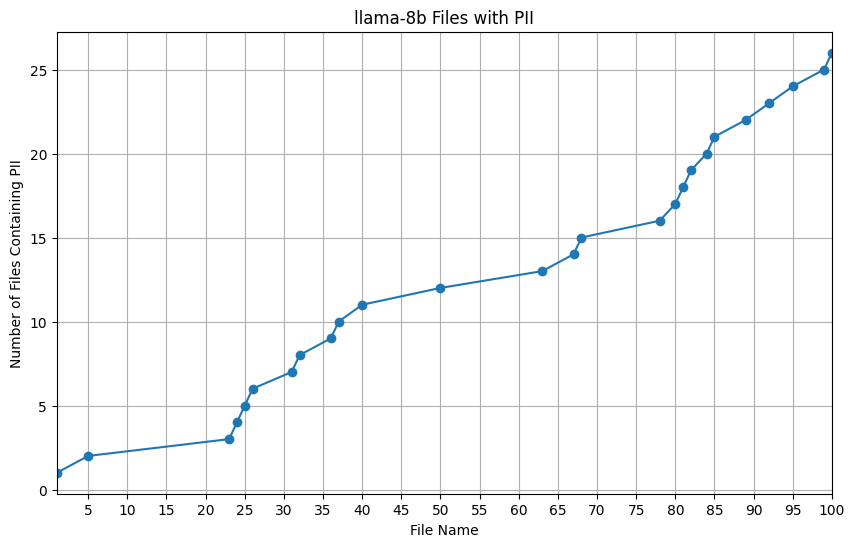

In [168]:

def create_cumulative_graph(yes_files_llama_8b, total_files):
    x = []
    y = []
    
    cumulative_count = 0
    for i in range(total_files):
        if f"text_{i+1}.txt" in yes_files_llama_8b:
            cumulative_count += 1
            x.append(i + 1)
            y.append(cumulative_count)

    plt.figure(figsize=(10, 6))
    plt.plot(x, y, marker="o")
    plt.xlabel("File Name")
    plt.ylabel("Number of Files Containing PII")
    plt.title("llama-8b Files with PII")
    plt.xticks(range(0, total_files + 1, 5))
    plt.grid(True)
    plt.xlim(1, total_files)
    plt.show()

# There is 100 text files
total_files = 100

# Create the cumulative graph
create_cumulative_graph(yes_files_llama_8b, total_files)


**Testing Agent for llama-3-70b using GPT-4-Turbo**

In [171]:
prompt_template = f"""
Granska följande text och ange om den innehåller någon personlig identifierbar information som namn, telefonnummer, e-postadresser, adresser eller andra identifierbara uppgifter.
Anonymizerad text räknas inte som personlig identifierbar information.
Svara endast med 'ja' eller 'nej':

"""
    
def check_for_pii(text):
    prompt = prompt_template + "\n\nText:\n" + text
    response = requests.post(
        url="https://openrouter.ai/api/v1/chat/completions",
        headers={
            "Authorization": f"Bearer {OPENROUTER_API_KEY}",
            "Content-Type": "application/json"
        },
        data=json.dumps({
            "model": "openai/gpt-4-turbo",
            "messages": [
                {"role": "system", "content": "Du är en hjälpful assistent, designad för att granska text data och svara med ja eller nej."},
                {"role": "user", "content": prompt}
            ],
            "temperature": 0.1,
            "max_tokens": 1,
            "top_p": 1.0,
        })
    )

    if response.status_code == 200:
        response_data = response.json()
        return response_data["choices"][0]["message"]["content"]
    else:
        raise Exception(f"API request failed with status code {response.status_code}: {response.text}")


def process_folder(input_folder):
    yes_files_llama_70b = []
    no_files_llama_70b = []
    errors_llama_70b = 0

    # Loop through each file in the directory
    for i, filename in enumerate(os.listdir(input_folder)):
        file_path = os.path.join(input_folder, filename)
        
        if os.path.isfile(file_path):
            with open(file_path, "r", encoding="utf-8") as file:
                text = file.read()
            
            try:
                response = check_for_pii(text)
                if response.strip().lower() == "ja":
                    yes_files_llama_70b.append(filename)  # Store the file name to later plot the graph
                    print(filename)
                elif response.strip().lower() == "nej":
                    no_files_llama_70b.append(filename)
            except Exception as e:
                print(f"Error processing file {filename}: {str(e)}")
                errors_llama_70b += 1

    return yes_files_llama_70b, no_files_llama_70b, errors_llama_70b

input_folder = "anonymized_texts/llama70b"

yes_files_llama_70b, no_files_llama_70b, error_count_llama_70b = process_folder(input_folder)

print(f"Files with PII: {len(yes_files_llama_70b)}")
print(f"Files without PII: {len(no_files_llama_70b)}")
print(f"Errors encountered: {error_count_llama_70b}")

text_1.txt
text_14.txt
text_16.txt
text_2.txt
text_22.txt
text_24.txt
text_27.txt
text_3.txt
text_30.txt
text_31.txt
text_40.txt
text_45.txt
text_58.txt
text_65.txt
text_67.txt
text_68.txt
text_80.txt
text_82.txt
text_84.txt
text_85.txt
text_89.txt
text_92.txt
Files with PII: 22
Files without PII: 78
Errors encountered: 0


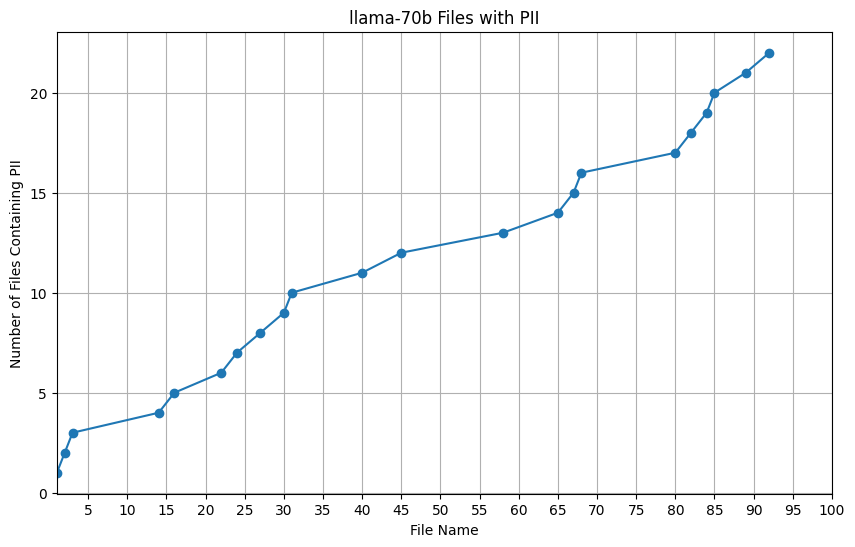

In [172]:

def create_graph(yes_files_llama_70b, total_files):
    x = []
    y = []
    
    cumulative_count = 0
    for i in range(total_files):
        if f"text_{i+1}.txt" in yes_files_llama_70b:
            cumulative_count += 1
            x.append(i + 1)
            y.append(cumulative_count)

    plt.figure(figsize=(10, 6))
    plt.plot(x, y, marker="o")
    plt.xlabel("File Name")
    plt.ylabel("Number of Files Containing PII")
    plt.title("llama-70b Files with PII")
    plt.xticks(range(0, total_files + 1, 5))
    plt.grid(True)
    plt.xlim(1, total_files)
    plt.show()

# There is 100 text files
total_files = 100

# Create the cumulative graph
create_graph(yes_files_llama_70b, total_files)


**Testing Agent for llama-3-70b using GPT-4-Turbo**

In [174]:
prompt_template = f"""
Granska följande text och ange om den innehåller någon personlig identifierbar information som namn, telefonnummer, e-postadresser, adresser eller andra identifierbara uppgifter.
Anonymizerad text räknas inte som personlig identifierbar information.
Svara endast med 'ja' eller 'nej':

"""
    
def check_for_pii(text):
    prompt = prompt_template + "\n\nText:\n" + text
    response = requests.post(
        url="https://openrouter.ai/api/v1/chat/completions",
        headers={
            "Authorization": f"Bearer {OPENROUTER_API_KEY}",
            "Content-Type": "application/json"
        },
        data=json.dumps({
            "model": "openai/gpt-4-turbo",
            "messages": [
                {"role": "system", "content": "Du är en hjälpful assistent, designad för att granska text data och svara med ja eller nej."},
                {"role": "user", "content": prompt}
            ],
            "temperature": 0.1,
            "max_tokens": 1,
            "top_p": 1.0,
        })
    )

    if response.status_code == 200:
        response_data = response.json()
        return response_data["choices"][0]["message"]["content"]
    else:
        raise Exception(f"API request failed with status code {response.status_code}: {response.text}")


def process_folder(input_folder):
    yes_files_qwen_110b = []
    no_files_qwen_110b = []
    errors_qwen_110b = 0

    # Loop through each file in the directory
    for i, filename in enumerate(os.listdir(input_folder)):
        file_path = os.path.join(input_folder, filename)
        
        if os.path.isfile(file_path):
            with open(file_path, "r", encoding="utf-8") as file:
                text = file.read()
            
            try:
                response = check_for_pii(text)
                if response.strip().lower() == "ja":
                    yes_files_qwen_110b.append(filename)  # Store the file name to later plot the graph
                    print(filename)
                elif response.strip().lower() == "nej":
                    no_files_qwen_110b.append(filename)
            except Exception as e:
                print(f"Error processing file {filename}: {str(e)}")
                errors_qwen_110b += 1

    return yes_files_qwen_110b, no_files_qwen_110b, errors_qwen_110b

input_folder = "anonymized_texts/qwen110b"

yes_files_qwen_110b, no_files_qwen_110b, error_count_qwen_110b = process_folder(input_folder)

print(f"Files with PII: {len(yes_files_qwen_110b)}")
print(f"Files without PII: {len(no_files_qwen_110b)}")
print(f"Errors encountered: {error_count_qwen_110b}")

text_10.txt
text_16.txt
text_17.txt
text_18.txt
text_20.txt
text_21.txt
text_24.txt
text_27.txt
text_3.txt
text_30.txt
text_38.txt
text_45.txt
text_48.txt
text_57.txt
text_58.txt
text_61.txt
text_66.txt
text_68.txt
text_74.txt
text_75.txt
text_78.txt
text_79.txt
text_82.txt
text_84.txt
text_85.txt
text_86.txt
text_89.txt
text_93.txt
text_94.txt
text_95.txt
text_96.txt
Files with PII: 31
Files without PII: 69
Errors encountered: 0


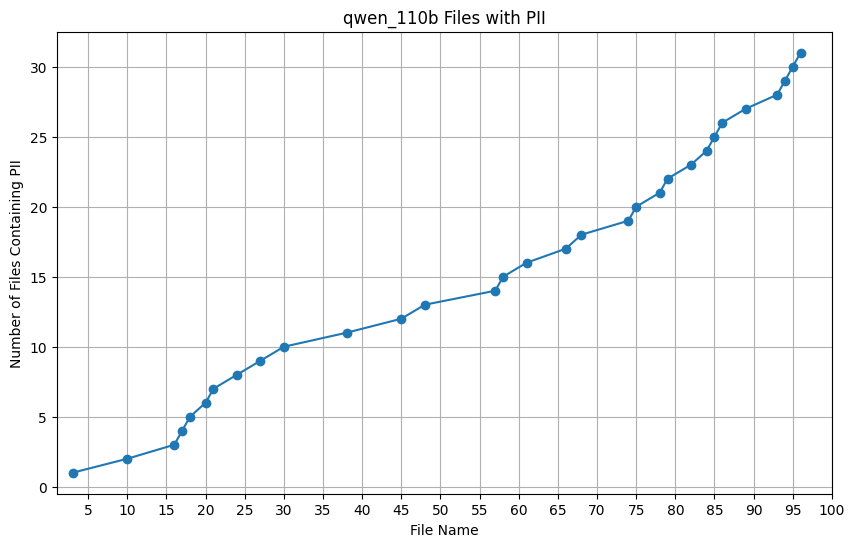

In [175]:

def create_graph(yes_files_qwen_110b, total_files):
    x = []
    y = []
    
    cumulative_count = 0
    for i in range(total_files):
        if f"text_{i+1}.txt" in yes_files_qwen_110b:
            cumulative_count += 1
            x.append(i + 1)
            y.append(cumulative_count)

    plt.figure(figsize=(10, 6))
    plt.plot(x, y, marker="o")
    plt.xlabel("File Name")
    plt.ylabel("Number of Files Containing PII")
    plt.title("qwen_110b Files with PII")
    plt.xticks(range(0, total_files + 1, 5))
    plt.grid(True)
    plt.xlim(1, total_files)
    plt.show()

# There is 100 text files
total_files = 100

# Create the cumulative graph
create_graph(yes_files_qwen_110b, total_files)


In [181]:
prompt_template = f"""
Granska följande text och ange om den innehåller någon personlig identifierbar information som namn, telefonnummer, e-postadresser, adresser eller andra identifierbara uppgifter.
Anonymizerad text räknas inte som personlig identifierbar information.
Svara endast med 'ja' eller 'nej':

"""
    
def check_for_pii(text):
    prompt = prompt_template + "\n\nText:\n" + text
    response = requests.post(
        url="https://openrouter.ai/api/v1/chat/completions",
        headers={
            "Authorization": f"Bearer {OPENROUTER_API_KEY}",
            "Content-Type": "application/json"
        },
        data=json.dumps({
            "model": "openai/gpt-4-turbo",
            "messages": [
                {"role": "system", "content": "Du är en hjälpful assistent, designad för att granska text data och svara med ja eller nej."},
                {"role": "user", "content": prompt}
            ],
            "temperature": 0.1,
            "max_tokens": 1,
            "top_p": 1.0,
        })
    )

    if response.status_code == 200:
        response_data = response.json()
        return response_data["choices"][0]["message"]["content"]
    else:
        raise Exception(f"API request failed with status code {response.status_code}: {response.text}")


def process_folder(input_folder):
    yes_files_final_system = []
    no_files_final_system = []
    errors_final_system = 0

    # Loop through each file in the directory
    for i, filename in enumerate(os.listdir(input_folder)):
        file_path = os.path.join(input_folder, filename)
        
        if os.path.isfile(file_path):
            with open(file_path, "r", encoding="utf-8") as file:
                text = file.read()
            
            try:
                response = check_for_pii(text)
                if response.strip().lower() == "ja":
                    yes_files_final_system.append(filename)  # Store the file name to later plot the graph
                    print(filename)
                elif response.strip().lower() == "nej":
                    no_files_final_system.append(filename)
            except Exception as e:
                print(f"Error processing file {filename}: {str(e)}")
                errors_final_system+= 1

    return yes_files_final_system, no_files_final_system, errors_final_system

input_folder = "PiiAnonymizer/Anonymized_texts"

yes_files_final_system, no_files_final_system, errors_final_system = process_folder(input_folder)

print(f"Files with PII: {len(yes_files_final_system)}")
print(f"Files without PII: {len(no_files_final_system)}")
print(f"Errors encountered: {error_count_final_system}")

text_62.txt
Files with PII: 1
Files without PII: 99


NameError: name 'error_count_final_system' is not defined

In [179]:
data = {
    "Model": ['Presidio', 'llama-3-70b', 'llama-3-8b','qwen-110b'],
    "Without PII": [1, 78, 74, 69],
    "Processing Time (s)": [0, 733, 406, 639],
    "Processing Time per File (s)": [0, 7.33, 4.06, 6.39],
    "Cost per Million Tokens": [0, 0.81, 0.18 , 1.62]
}

df = pd.DataFrame(data)

df.to_excel('results.xlsx', index=False)

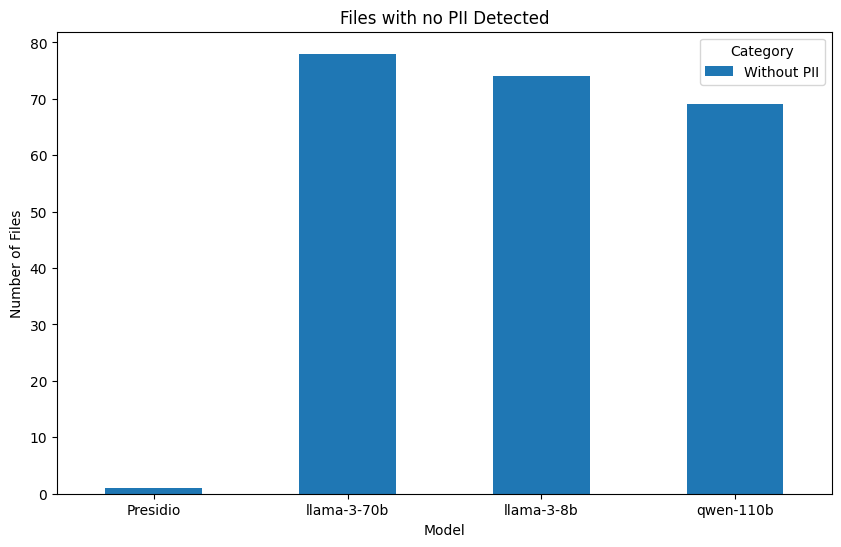

In [177]:

ax = df.set_index('Model')['Without PII'].plot(kind='bar', stacked=False, figsize=(10, 6))

# Title and labels
plt.title('Files with no PII Detected')
plt.xlabel('Model')
plt.ylabel('Number of Files')
plt.xticks(rotation=0) 
plt.legend(title='Category')
plt.show()

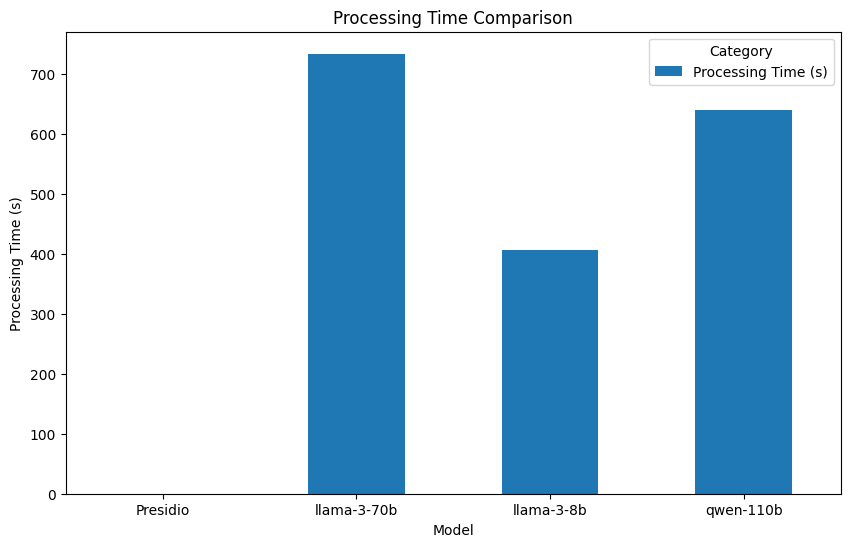

In [137]:
ax = df.set_index('Model')['Processing Time (s)'].plot(kind='bar', stacked=False, figsize=(10, 6))
plt.xlabel('Model')
plt.ylabel('Processing Time (s)')
plt.title('Processing Time Comparison')
plt.xticks(rotation=0)
plt.legend(title='Category')
plt.show()


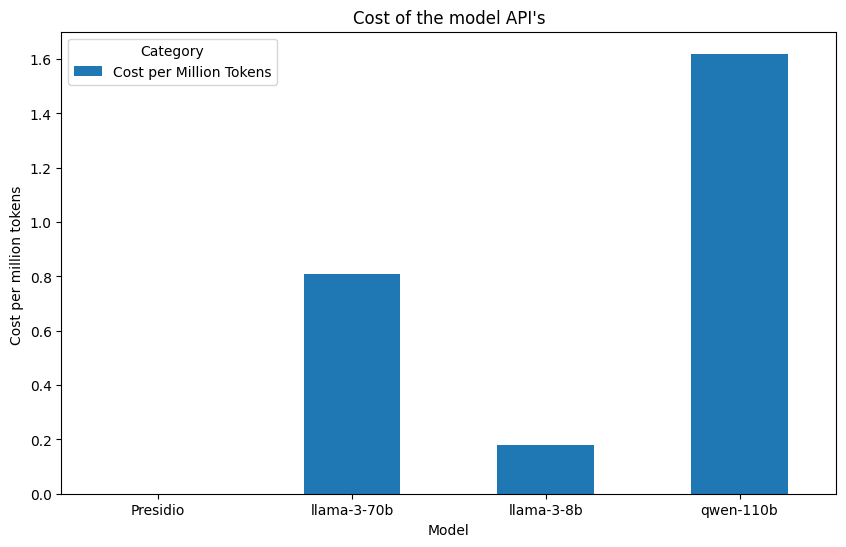

In [180]:
ax = df.set_index('Model')['Cost per Million Tokens'].plot(kind='bar', stacked=False, figsize=(10, 6))

# Title and labels
plt.title("Cost of the model API's")
plt.xlabel("Model")
plt.ylabel('Cost per million tokens ')
plt.xticks(rotation=0) 
plt.legend(title='Category')
plt.show()